Import necessary packages

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Load the Data

In [108]:
# Load Scala benchmark data
scala_idle_data = pd.read_csv('../data/20250309091438_ping_pong_akka_actor_benchmark_idle_power.csv')
scala_bench_data = pd.read_csv('../data/20250309091449_ping_pong_akka_actor_benchmark_power_metrics.csv')

# Load Erlang benchmark data
erlang_idle_data = pd.read_csv('../data/20250309091714_ping_pong_benchmark_idle_power.csv')
erlang_bench_data = pd.read_csv('../data/20250309091725_ping_pong_benchmark_power_metrics.csv')

Preview the Data

In [109]:
print("Scala Idle Data Sample:")
print(scala_idle_data.shape)
scala_idle_data.head()

Scala Idle Data Sample:
(10, 9)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level
0,(Sun Mar 9 09:14:38 2025 +0100) (508.87ms elap...,6.85,0.0870,1.200,9.53,1.28,64.83,63.28 C,Nominal
1,(Sun Mar 9 09:14:39 2025 +0100) (504.32ms elap...,18.80,0.0715,1.060,23.37,2.27,93.32,63.28 C,Nominal
2,(Sun Mar 9 09:14:39 2025 +0100) (503.86ms elap...,12.90,0.0844,1.080,17.31,1.78,86.82,64.32 C,Nominal
3,(Sun Mar 9 09:14:40 2025 +0100) (507.18ms elap...,1.16,0.0149,0.834,3.42,0.83,44.37,64.32 C,Nominal
4,(Sun Mar 9 09:14:40 2025 +0100) (508.37ms elap...,12.50,0.3330,1.650,15.96,2.36,81.63,63.89 C,Nominal


In [110]:
print("Scala Benchmark Data Sample:")
print(scala_bench_data.shape)
scala_bench_data.head()

Scala Benchmark Data Sample:
(18, 9)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level
0,(Sun Mar 9 09:14:50 2025 +0100) (506.91ms elap...,36.2,0.1320,0.898,41.08,3.71,98.37,63.57 C,Nominal
1,(Sun Mar 9 09:14:50 2025 +0100) (506.08ms elap...,36.7,0.0439,0.830,41.01,3.93,98.74,67.97 C,Nominal
2,(Sun Mar 9 09:14:51 2025 +0100) (507.19ms elap...,36.7,0.0780,0.730,40.78,3.93,98.84,67.97 C,Nominal
3,(Sun Mar 9 09:14:51 2025 +0100) (505.01ms elap...,36.2,0.0000,0.600,39.92,3.89,98.01,71.21 C,Nominal
4,(Sun Mar 9 09:14:52 2025 +0100) (504.45ms elap...,36.5,0.0405,0.634,40.31,3.87,97.71,71.21 C,Nominal


In [111]:
print("Erlang Idle Data Sample:")
print(erlang_idle_data.shape)
erlang_idle_data.head()

Erlang Idle Data Sample:
(10, 9)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level
0,(Sun Mar 9 09:17:15 2025 +0100) (508.86ms elap...,6.29,0.0746,0.991,8.66,0.93,52.55,61.07 C,Nominal
1,(Sun Mar 9 09:17:15 2025 +0100) (506.17ms elap...,9.73,0.0828,1.090,12.50,1.35,64.07,61.14 C,Nominal
2,(Sun Mar 9 09:17:16 2025 +0100) (504.71ms elap...,5.95,0.1820,1.220,8.66,1.29,64.61,61.14 C,Nominal
3,(Sun Mar 9 09:17:16 2025 +0100) (508.35ms elap...,3.71,0.1420,1.230,6.38,1.44,65.31,61.11 C,Nominal
4,(Sun Mar 9 09:17:17 2025 +0100) (506.54ms elap...,1.93,0.0352,1.020,4.43,1.22,59.22,61.11 C,Nominal


In [112]:
print("Erlang Benchmark Data Sample:")
print(erlang_bench_data.shape)
erlang_bench_data.head()

Erlang Benchmark Data Sample:
(15, 9)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level
0,(Sun Mar 9 09:17:26 2025 +0100) (508.98ms elap...,18.7,0.0674,1.020,21.17,1.75,96.30,62.52 C,Nominal
1,(Sun Mar 9 09:17:27 2025 +0100) (505.48ms elap...,17.3,0.0651,0.843,19.65,1.59,96.38,64.73 C,Nominal
2,(Sun Mar 9 09:17:27 2025 +0100) (506.39ms elap...,15.2,0.1230,0.960,17.77,1.37,96.02,64.73 C,Nominal
3,(Sun Mar 9 09:17:28 2025 +0100) (505.97ms elap...,20.0,0.2300,0.877,24.53,2.07,96.60,66.88 C,Nominal
4,(Sun Mar 9 09:17:28 2025 +0100) (506.13ms elap...,16.3,0.2050,1.150,19.24,1.61,97.32,66.88 C,Nominal


Cleaning the Data


In [113]:
def clean_data(df):
    df_copy = df.copy() 

    # Convert Timestamp to datetime format (extract date-time pattern)
    df_copy['Timestamp'] = pd.to_datetime(
        df['Timestamp'].str.extract(r'(\w{3} \w{3} \d{1,2} \d{2}:\d{2}:\d{2} \d{4})')[0], 
        errors='coerce'
    )

    # Extract elapsed time in milliseconds
    df_copy['Time Elapsed (ms)'] = pd.to_numeric(
        df['Timestamp'].str.extract(r'\((\d+\.\d+)ms elapsed\)')[0], 
        errors='coerce'
    )
    
    # Extract numeric temperature values
    df_copy['CPU Temp(C)'] = df['CPU Temp(C)'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    # Calculate Energy columns (Power * Time Elapsed)
    power_columns = ["CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", "(CPUs+GT+SA) Power(W)"]
    for column in power_columns:
        energy_column = column.replace('Power(W)', 'Energy(J)')
        df_copy[energy_column] = df_copy[column] * df_copy['Time Elapsed (ms)'] / 1000  # Convert ms to seconds


    return df_copy

In [114]:
scala_idle_data_clean = clean_data(scala_idle_data)
scala_bench_data_clean = clean_data(scala_bench_data)
erlang_idle_data_clean = clean_data(erlang_idle_data)
erlang_bench_data_clean = clean_data(erlang_bench_data)

Verify Cleaned Data

In [115]:
print("Scala Idle Cleaned Data Sample:")
print(scala_idle_data_clean.shape)
scala_idle_data_clean.head()


Scala Idle Cleaned Data Sample:
(10, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
0,2025-03-09 09:14:38,6.85,0.0870,1.200,9.53,1.28,64.83,63.28,Nominal,508.87,3.485759,0.044272,0.610644,4.849531
1,2025-03-09 09:14:39,18.80,0.0715,1.060,23.37,2.27,93.32,63.28,Nominal,504.32,9.481216,0.036059,0.534579,11.785958
2,2025-03-09 09:14:39,12.90,0.0844,1.080,17.31,1.78,86.82,64.32,Nominal,503.86,6.499794,0.042526,0.544169,8.721817
3,2025-03-09 09:14:40,1.16,0.0149,0.834,3.42,0.83,44.37,64.32,Nominal,507.18,0.588329,0.007557,0.422988,1.734556
4,2025-03-09 09:14:40,12.50,0.3330,1.650,15.96,2.36,81.63,63.89,Nominal,508.37,6.354625,0.169287,0.838810,8.113585


In [116]:
print("Scala Benchmark Cleaned Data Sample:")
print(scala_bench_data_clean.shape)
scala_bench_data_clean.head()


Scala Benchmark Cleaned Data Sample:
(18, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
0,2025-03-09 09:14:50,36.2,0.1320,0.898,41.08,3.71,98.37,63.57,Nominal,506.91,18.350142,0.066912,0.455205,20.823863
1,2025-03-09 09:14:50,36.7,0.0439,0.830,41.01,3.93,98.74,67.97,Nominal,506.08,18.573136,0.022217,0.420046,20.754341
2,2025-03-09 09:14:51,36.7,0.0780,0.730,40.78,3.93,98.84,67.97,Nominal,507.19,18.613873,0.039561,0.370249,20.683208
3,2025-03-09 09:14:51,36.2,0.0000,0.600,39.92,3.89,98.01,71.21,Nominal,505.01,18.281362,0.000000,0.303006,20.159999
4,2025-03-09 09:14:52,36.5,0.0405,0.634,40.31,3.87,97.71,71.21,Nominal,504.45,18.412425,0.020430,0.319821,20.334380


In [117]:
print("Erlang Idle Cleaned Data Sample:")
print(erlang_idle_data_clean.shape)
erlang_idle_data_clean.head()


Erlang Idle Cleaned Data Sample:
(10, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
0,2025-03-09 09:17:15,6.29,0.0746,0.991,8.66,0.93,52.55,61.07,Nominal,508.86,3.200729,0.037961,0.504280,4.406728
1,2025-03-09 09:17:15,9.73,0.0828,1.090,12.50,1.35,64.07,61.14,Nominal,506.17,4.925034,0.041911,0.551725,6.327125
2,2025-03-09 09:17:16,5.95,0.1820,1.220,8.66,1.29,64.61,61.14,Nominal,504.71,3.003024,0.091857,0.615746,4.370789
3,2025-03-09 09:17:16,3.71,0.1420,1.230,6.38,1.44,65.31,61.11,Nominal,508.35,1.885979,0.072186,0.625270,3.243273
4,2025-03-09 09:17:17,1.93,0.0352,1.020,4.43,1.22,59.22,61.11,Nominal,506.54,0.977622,0.017830,0.516671,2.243972


In [118]:
print("Erlang Benchmark Cleaned Data Sample:")
print(erlang_bench_data_clean.shape)
erlang_bench_data_clean.head()

Erlang Benchmark Cleaned Data Sample:
(15, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
0,2025-03-09 09:17:26,18.7,0.0674,1.020,21.17,1.75,96.30,62.52,Nominal,508.98,9.517926,0.034305,0.519160,10.775107
1,2025-03-09 09:17:27,17.3,0.0651,0.843,19.65,1.59,96.38,64.73,Nominal,505.48,8.744804,0.032907,0.426120,9.932682
2,2025-03-09 09:17:27,15.2,0.1230,0.960,17.77,1.37,96.02,64.73,Nominal,506.39,7.697128,0.062286,0.486134,8.998550
3,2025-03-09 09:17:28,20.0,0.2300,0.877,24.53,2.07,96.60,66.88,Nominal,505.97,10.119400,0.116373,0.443736,12.411444
4,2025-03-09 09:17:28,16.3,0.2050,1.150,19.24,1.61,97.32,66.88,Nominal,506.13,8.249919,0.103757,0.582049,9.737941


Handling Outliers


In [119]:
def remove_outliers(df, columns):
    """
    Removes outliers from the specified columns using the IQR method.
    """
    df_clean = df.copy()
    
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    
    return df_clean

In [120]:
# Columns of interest for outlier removal
columns_of_interest = [
    "CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", 
    "(CPUs+GT+SA) Power(W)", "Avg Num Cores Active", "CPU Temp(C)"
]

scala_idle_data_clean_outlier = remove_outliers(scala_idle_data_clean, columns_of_interest)
scala_bench_data_clean_outlier = remove_outliers(scala_bench_data_clean, columns_of_interest)
erlang_idle_data_clean_outlier = remove_outliers(erlang_idle_data_clean, columns_of_interest)
erlang_bench_data_clean_outlier = remove_outliers(erlang_bench_data_clean, columns_of_interest)

In [121]:
print("Scala Idle Cleaned Data After Outlier Removal: ")
print(scala_idle_data_clean_outlier.shape)
scala_idle_data_clean_outlier.head()


Scala Idle Cleaned Data After Outlier Removal: 
(6, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
0,2025-03-09 09:14:38,6.850,0.087000,1.200,9.53,1.28,64.83,63.28,Nominal,508.87,3.485759,0.044272,0.610644,4.849531
5,2025-03-09 09:14:41,2.570,0.071100,0.874,5.36,0.77,38.24,63.89,Nominal,506.44,1.301551,0.036008,0.442629,2.714518
6,2025-03-09 09:14:41,2.650,0.102000,0.949,5.13,0.88,49.14,63.45,Nominal,508.25,1.346862,0.051841,0.482329,2.607322
7,2025-03-09 09:14:42,0.558,0.021200,0.682,2.65,0.38,23.81,63.45,Nominal,507.78,0.283341,0.010765,0.346306,1.345617
8,2025-03-09 09:14:42,0.860,0.000961,0.665,2.92,0.54,31.59,63.22,Nominal,508.22,0.437069,0.000488,0.337966,1.484002


In [122]:
print("Scala Benchmark Cleaned Data After Outlier Removal: ")
print(scala_bench_data_clean_outlier.shape)
scala_bench_data_clean_outlier.head()

Scala Benchmark Cleaned Data After Outlier Removal: 
(15, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
1,2025-03-09 09:14:50,36.7,0.0439,0.830,41.01,3.93,98.74,67.97,Nominal,506.08,18.573136,0.022217,0.420046,20.754341
2,2025-03-09 09:14:51,36.7,0.0780,0.730,40.78,3.93,98.84,67.97,Nominal,507.19,18.613873,0.039561,0.370249,20.683208
3,2025-03-09 09:14:51,36.2,0.0000,0.600,39.92,3.89,98.01,71.21,Nominal,505.01,18.281362,0.000000,0.303006,20.159999
4,2025-03-09 09:14:52,36.5,0.0405,0.634,40.31,3.87,97.71,71.21,Nominal,504.45,18.412425,0.020430,0.319821,20.334380
5,2025-03-09 09:14:52,35.9,0.0350,0.721,39.94,3.91,98.45,73.61,Nominal,505.88,18.161092,0.017706,0.364739,20.204847


In [123]:
print("Erlang Idle Cleaned Data After Outlier Removal: ")
print(erlang_idle_data_clean_outlier.shape)
erlang_idle_data_clean_outlier.head()

Erlang Idle Cleaned Data After Outlier Removal: 
(5, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
0,2025-03-09 09:17:15,6.29,0.0746,0.991,8.66,0.93,52.55,61.07,Nominal,508.86,3.200729,0.037961,0.504280,4.406728
1,2025-03-09 09:17:15,9.73,0.0828,1.090,12.50,1.35,64.07,61.14,Nominal,506.17,4.925034,0.041911,0.551725,6.327125
2,2025-03-09 09:17:16,5.95,0.1820,1.220,8.66,1.29,64.61,61.14,Nominal,504.71,3.003024,0.091857,0.615746,4.370789
3,2025-03-09 09:17:16,3.71,0.1420,1.230,6.38,1.44,65.31,61.11,Nominal,508.35,1.885979,0.072186,0.625270,3.243273
4,2025-03-09 09:17:17,1.93,0.0352,1.020,4.43,1.22,59.22,61.11,Nominal,506.54,0.977622,0.017830,0.516671,2.243972


In [124]:
print("Erlang Benchmark Cleaned Data After Outlier Removal: ")
print(erlang_bench_data_clean_outlier.shape)
erlang_bench_data_clean_outlier.head()

Erlang Benchmark Cleaned Data After Outlier Removal: 
(15, 14)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms),CPU Core Energy(J),GT Energy(J),DRAM Energy(J),(CPUs+GT+SA) Energy(J)
0,2025-03-09 09:17:26,18.7,0.0674,1.020,21.17,1.75,96.30,62.52,Nominal,508.98,9.517926,0.034305,0.519160,10.775107
1,2025-03-09 09:17:27,17.3,0.0651,0.843,19.65,1.59,96.38,64.73,Nominal,505.48,8.744804,0.032907,0.426120,9.932682
2,2025-03-09 09:17:27,15.2,0.1230,0.960,17.77,1.37,96.02,64.73,Nominal,506.39,7.697128,0.062286,0.486134,8.998550
3,2025-03-09 09:17:28,20.0,0.2300,0.877,24.53,2.07,96.60,66.88,Nominal,505.97,10.119400,0.116373,0.443736,12.411444
4,2025-03-09 09:17:28,16.3,0.2050,1.150,19.24,1.61,97.32,66.88,Nominal,506.13,8.249919,0.103757,0.582049,9.737941


Visualization

In [178]:
# def plot_graphs(idle_df, bench_df, title_prefix):
#     """
#     Creates separate figures for each metric, plotting idle (left) and benchmark (right).
#     """
#     columns_to_plot = [
#         "CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", 
#         "(CPUs+GT+SA) Power(W)", "Avg Num Cores Active", "CPU Temp(C)"
#     ]
    
#     for column in columns_to_plot:
#         fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

#         # Idle (Left Side)
#         axes[0].plot(idle_df["Timestamp"], idle_df[column], color='blue', linestyle='--', label="Idle")
#         axes[0].set_title(f"Idle - {column}", fontsize=12)
#         axes[0].set_xlabel("Time", fontsize=10)
#         axes[0].set_ylabel(column)
#         axes[0].legend()
#         axes[0].grid(True)

#         # Format x-axis for better readability
#         axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#         axes[0].tick_params(axis='x', rotation=45)
          
#         # Benchmark (Right Side)
#         axes[1].plot(bench_df["Timestamp"], bench_df[column], color='red', linestyle='-', label="Benchmark")
#         axes[1].set_title(f"Benchmark - {column}")
#         axes[1].set_xlabel("Time")
#         axes[1].set_ylabel(column)
#         axes[1].legend()
#         axes[1].grid(True)

#         # Format x-axis for better readability
#         axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#         axes[1].tick_params(axis='x', rotation=45)

#         # Main figure title
#         fig.suptitle(f"{title_prefix} - {column}", fontsize=14)
        
#         plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
#         plt.show()
#         plt.close(fig)


def plot_graphs(idle_df, bench_df, title_prefix):
    """
    Creates side-by-side subplots for each metric, plotting idle (left) and benchmark (right).
    """
    columns_to_plot = [
        "CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", 
        "(CPUs+GT+SA) Power(W)", "Avg Num Cores Active", "CPU Temp(C)"
    ]
    
    # Set Seaborn theme
    sns.set_theme(style="whitegrid", palette="muted")
    
    for column in columns_to_plot:
        # Create side-by-side subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        # Plot Idle data on the first subplot
        sns.lineplot(data=idle_df, x="Timestamp", y=column, label="Idle", color='blue', linestyle='--', ax=axes[0])
        axes[0].set_title(f"Idle - {column}", fontsize=12)
        axes[0].set_xlabel("Time", fontsize=10)
        axes[0].set_ylabel(column, fontsize=10)
        axes[0].legend()
        axes[0].grid(True)

        # Format x-axis for better readability
        axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axes[0].tick_params(axis='x', rotation=45)

        # Plot Benchmark data on the second subplot
        sns.lineplot(data=bench_df, x="Timestamp", y=column, label="Benchmark", color='red', ax=axes[1])
        axes[1].set_title(f"Benchmark - {column}", fontsize=12)
        axes[1].set_xlabel("Time", fontsize=10)
        axes[1].set_ylabel(column, fontsize=10)
        axes[1].legend()
        axes[1].grid(True)

        # Format x-axis for better readability
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axes[1].tick_params(axis='x', rotation=45)

        # Main figure title
        fig.suptitle(f"{title_prefix} - {column}", fontsize=14)
        
        # Adjust layout to avoid overlap
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
        plt.show()


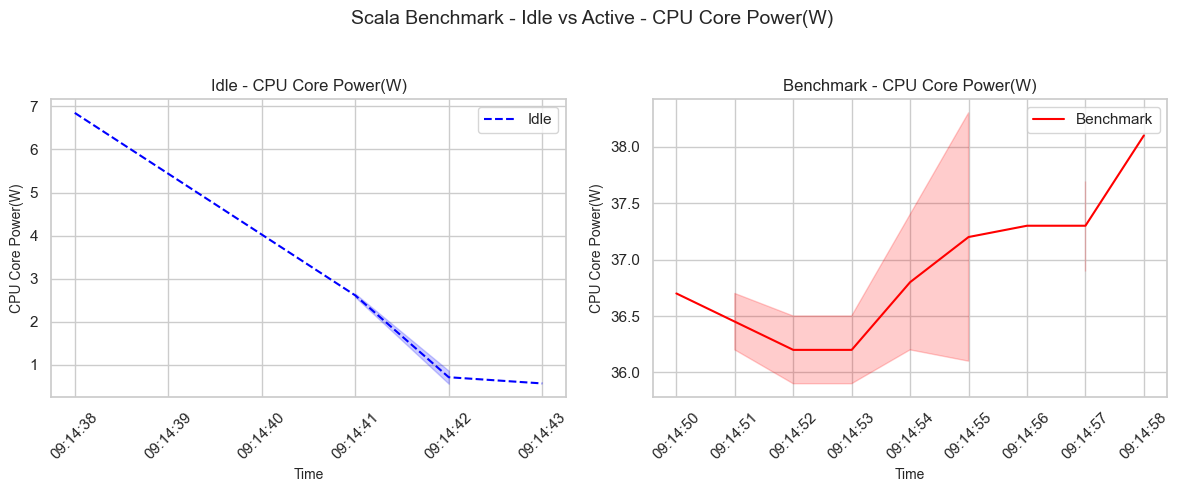

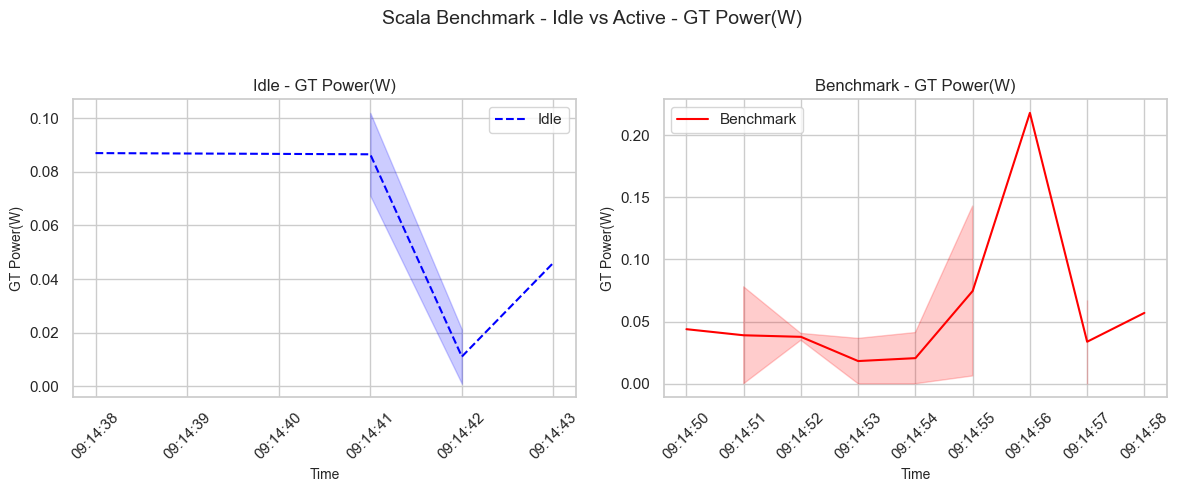

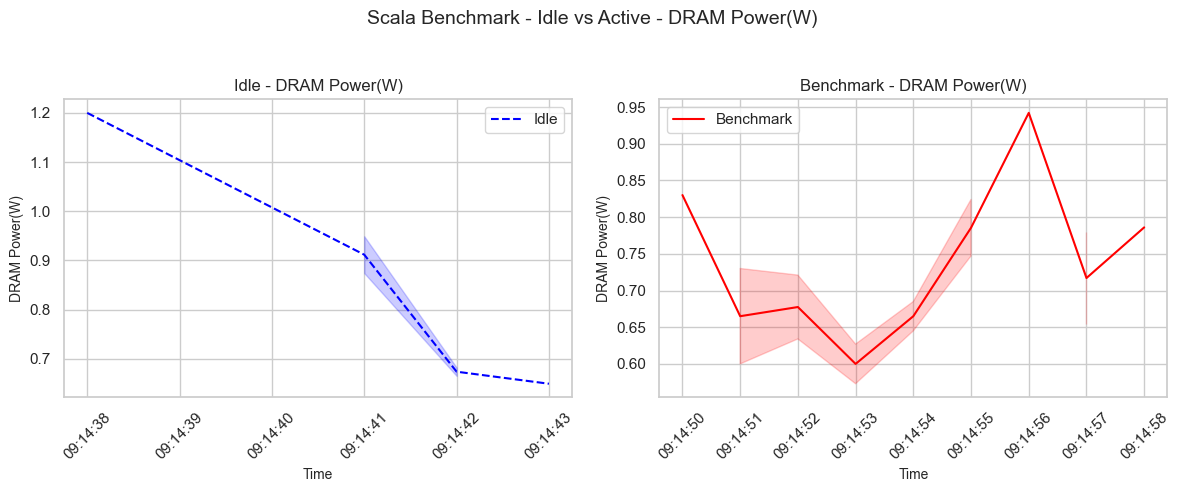

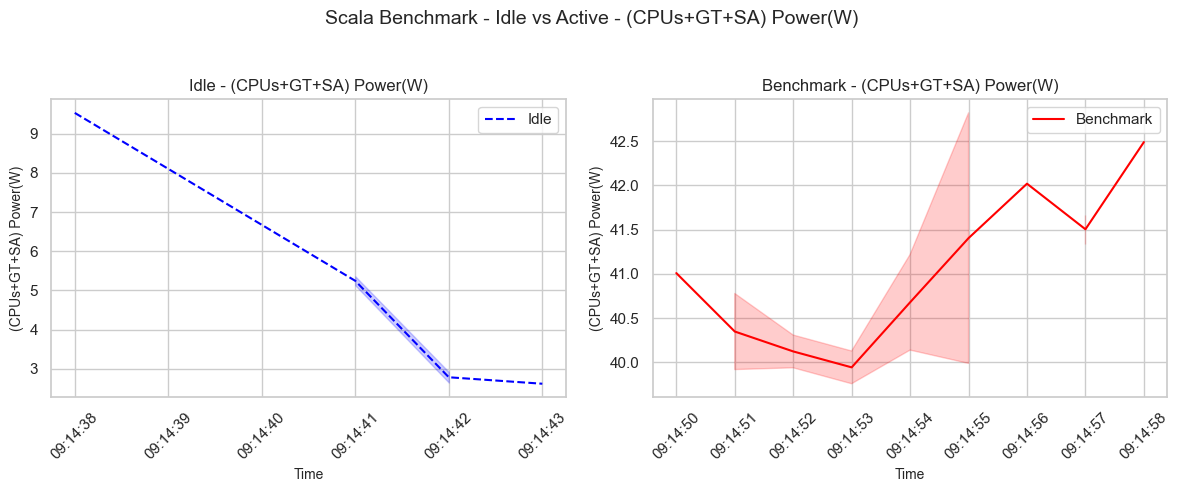

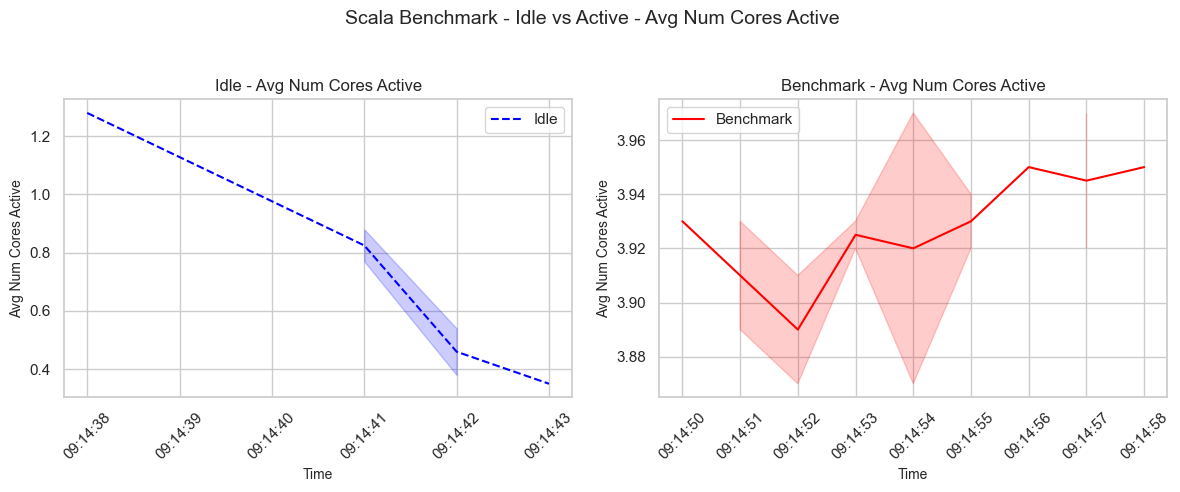

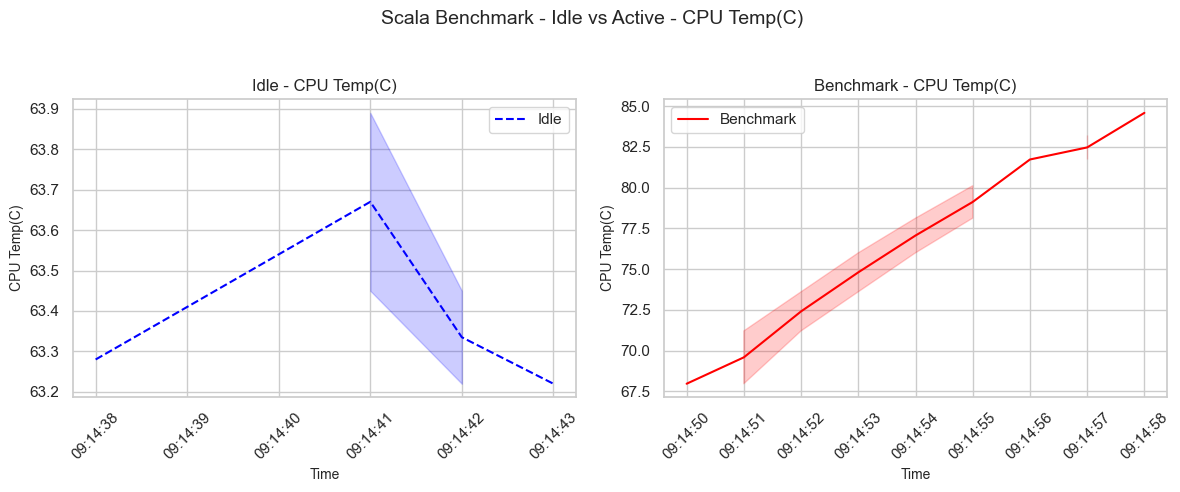

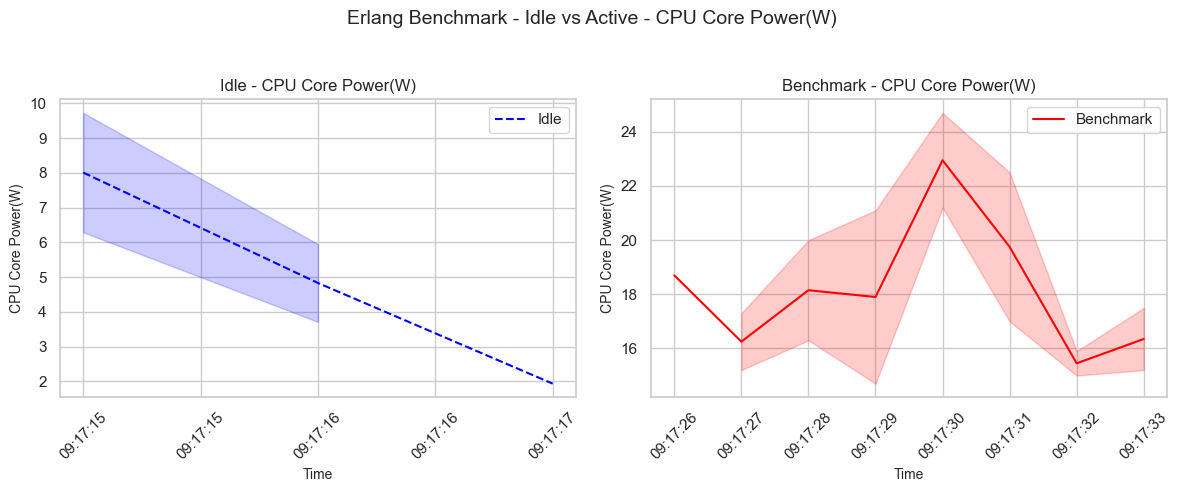

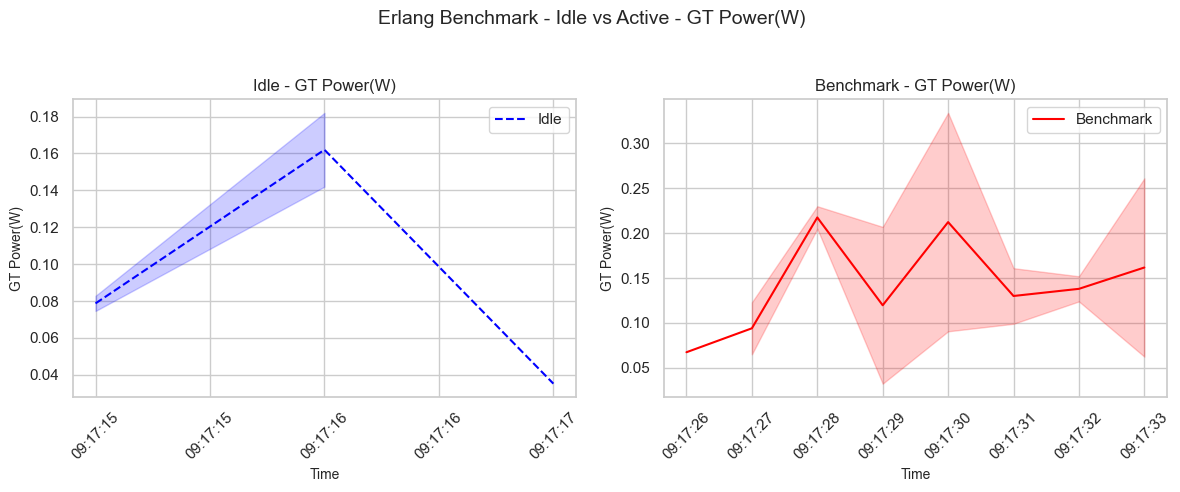

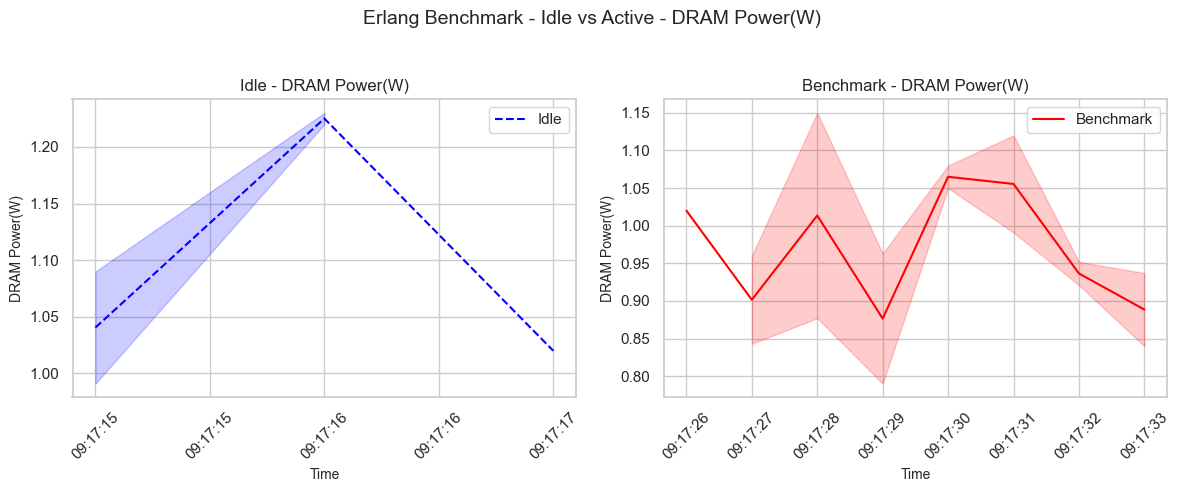

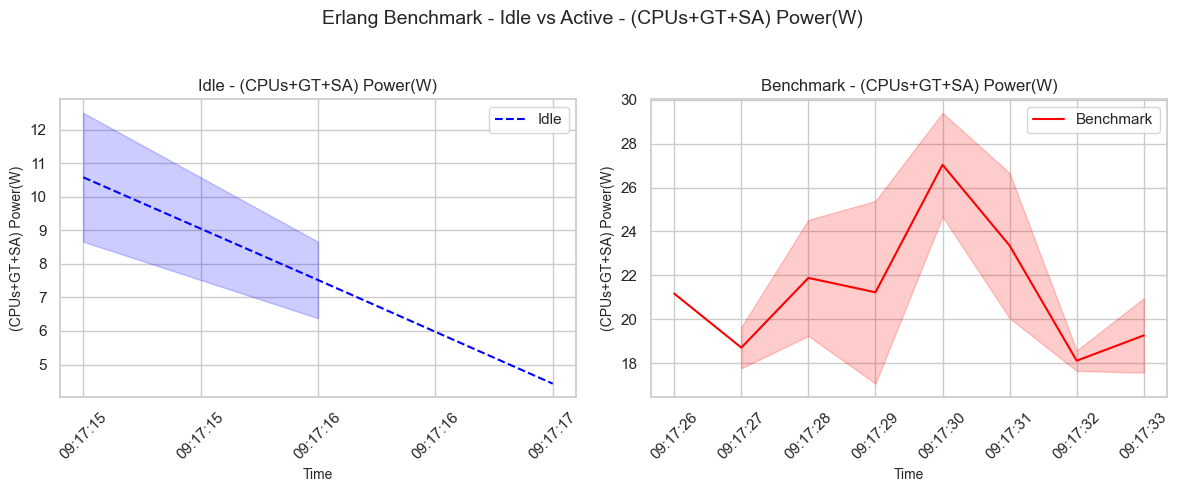

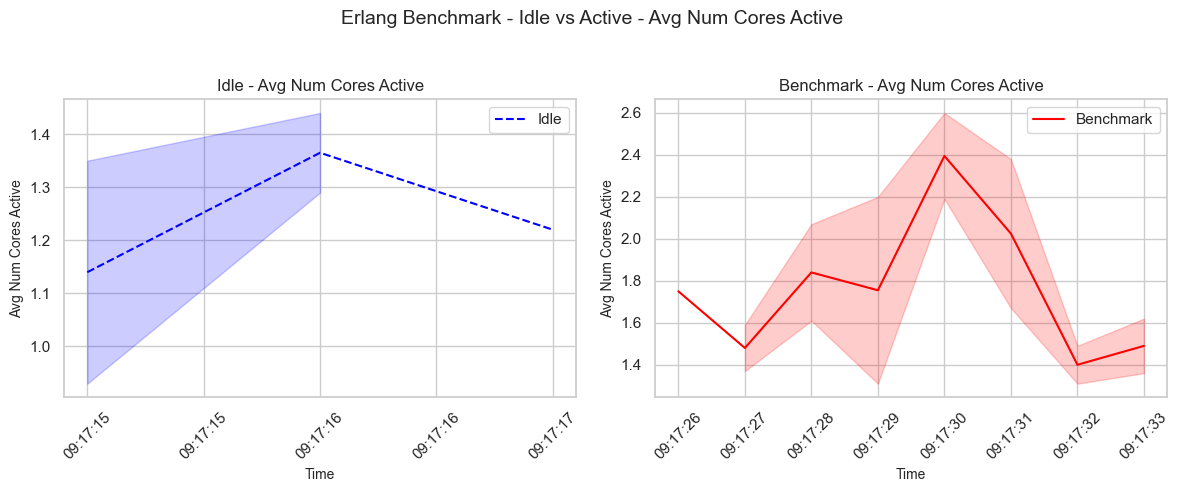

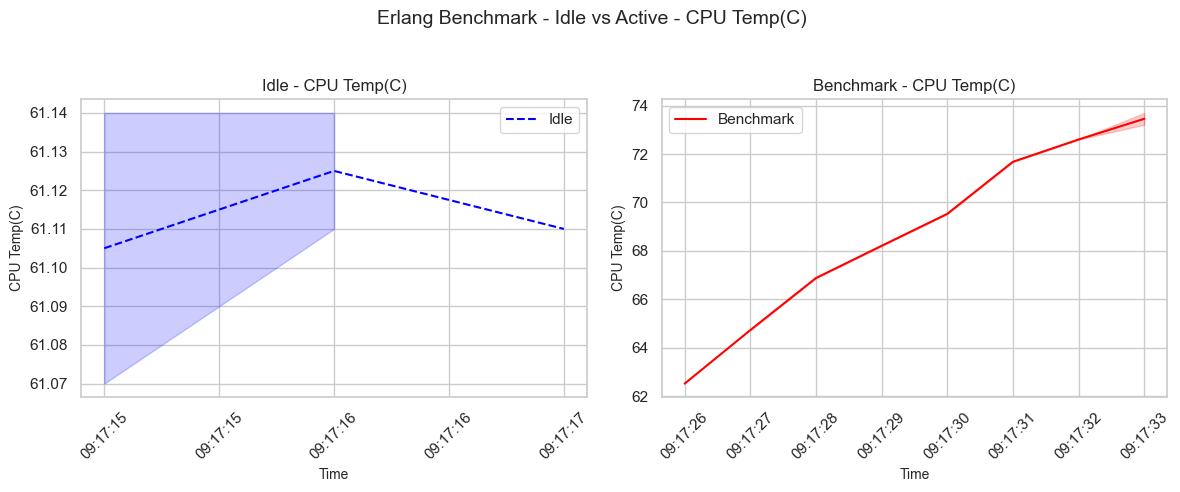

In [179]:
plot_graphs(scala_idle_data_clean_outlier, scala_bench_data_clean_outlier, "Scala Benchmark - Idle vs Active")
plot_graphs(erlang_idle_data_clean_outlier, erlang_bench_data_clean_outlier, "Erlang Benchmark - Idle vs Active")

Compute Average Power Consumption

In [127]:
metrics_columns = ["CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", "(CPUs+GT+SA) Power(W)","CPU Temp(C)", "Avg Num Cores Active"]

In [128]:
def calculate_average_benchmark_metrics(df, metrics_columns):
    """
    Calculates the average power consumption for the specified columns.
    """
    avg_power = df[metrics_columns].mean()
    return avg_power

scala_idle_avgs = calculate_average_benchmark_metrics(scala_idle_data_clean_outlier, metrics_columns)
erlang_idle_avgs = calculate_average_benchmark_metrics(erlang_idle_data_clean_outlier, metrics_columns)

scala_bench_avgs = calculate_average_benchmark_metrics(scala_bench_data_clean_outlier, metrics_columns)
erlang_bench_avgs = calculate_average_benchmark_metrics(erlang_bench_data_clean_outlier, metrics_columns)

scala_net_avgs = np.maximum(scala_bench_avgs - scala_idle_avgs, 0)
erlang_net_avgs = np.maximum(erlang_bench_avgs - erlang_idle_avgs, 0)


print("Net Average Metrics Comparison:\n")
print("Scala Benchmark:")
print(scala_net_avgs, "\n")
print("Erlang Benchmark:")
print(erlang_net_avgs)

Net Average Metrics Comparison:

Scala Benchmark:
CPU Core Power(W)        34.484500
GT Power(W)               0.000000
DRAM Power(W)             0.000000
(CPUs+GT+SA) Power(W)    36.201000
CPU Temp(C)              12.929667
Avg Num Cores Active      3.224667
dtype: float64 

Erlang Benchmark:
CPU Core Power(W)        12.631333
GT Power(W)               0.044293
DRAM Power(W)             0.000000
(CPUs+GT+SA) Power(W)    13.231333
CPU Temp(C)               7.998667
Avg Num Cores Active      0.522000
dtype: float64


Compute Energy Consumption

In [129]:
energy_columns = ["CPU Core Energy(J)", "GT Energy(J)", "DRAM Energy(J)", "(CPUs+GT+SA) Energy(J)"]

In [130]:
def calculate_net_energy(df, energy_columns):
    """
    Calculates the net energy consumption by subtracting idle energy from benchmark energy.
    """
    avg_energy = df[energy_columns].mean()

    return avg_energy

scala_idle_avg_energy = calculate_average_benchmark_metrics(scala_idle_data_clean_outlier, energy_columns)
erlang_idle_avg_energy = calculate_average_benchmark_metrics(erlang_idle_data_clean_outlier, energy_columns)

scala_bench_avg_energy = calculate_average_benchmark_metrics(scala_bench_data_clean_outlier, energy_columns)
erlang_bench_avg_energy = calculate_average_benchmark_metrics(erlang_bench_data_clean_outlier, energy_columns)

scala_net_avg_energy = np.maximum(scala_bench_avg_energy - scala_idle_avg_energy, 0)
erlang_net_avg_energy = np.maximum(erlang_bench_avg_energy - erlang_idle_avg_energy, 0)


print("Net Average Energy (Joules) Comparison:\n")
print("Scala Benchmark:")
print(scala_net_avg_energy, "\n")
print("Erlang Benchmark:")
print(erlang_net_avg_energy)


Net Average Energy (Joules) Comparison:

Scala Benchmark:
CPU Core Energy(J)        17.428836
GT Energy(J)               0.000000
DRAM Energy(J)             0.000000
(CPUs+GT+SA) Energy(J)    18.291104
dtype: float64 

Erlang Benchmark:
CPU Core Energy(J)        6.389571
GT Energy(J)              0.022353
DRAM Energy(J)            0.000000
(CPUs+GT+SA) Energy(J)    6.691220
dtype: float64


In [214]:
# def plot_normalized_comparison(erlang_df, scala_df, idle_erlang_df, idle_scala_df, title_prefix):
#     """
#     Plots Erlang and Scala benchmark data with elapsed time starting at t=0 (from 'Time Elapsed (ms)'),
#     after subtracting corresponding idle values.
#     """
#     columns_to_plot = [
#         "CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", 
#         "(CPUs+GT+SA) Power(W)", "Avg Num Cores Active", "CPU Temp(C)"
#     ]

#     sns.set_theme(style="whitegrid", palette="muted")

#     for column in columns_to_plot:
#         fig, ax = plt.subplots(figsize=(10, 5))

#         # Subtract idle values
#         erlang_df["Adjusted " + column] = erlang_df[column] - idle_erlang_df[column].mean()
#         scala_df["Adjusted " + column] = scala_df[column] - idle_scala_df[column].mean()

#         # Convert milliseconds to seconds for readability
#         erlang_df["Elapsed Time (s)"] = erlang_df["Time Elapsed (ms)"] / 1000
#         scala_df["Elapsed Time (s)"] = scala_df["Time Elapsed (ms)"] / 1000
     
#         sns.lineplot(data=erlang_df, x="Elapsed Time (s)", y="Adjusted " + column, label="Erlang", color='blue', marker='o', ax=ax)
#         sns.lineplot(data=scala_df, x="Elapsed Time (s)", y="Adjusted " + column, label="Scala", color='red', marker="o", ax=ax)



#         # Graph formatting
#         ax.set_title(f"{title_prefix} - {column} (Benchmark - Idle)", fontsize=14)
#         ax.set_xlabel("Elapsed Time (s)", fontsize=12)
#         ax.set_ylabel("Adjusted " + column, fontsize=12)
#         ax.legend()
#         ax.grid(True)

#         plt.tight_layout()
#         plt.show()



def plot_normalized_comparison(erlang_df, scala_df, idle_erlang_df, idle_scala_df, title_prefix):
    """
    Plots Erlang and Scala benchmark data with elapsed time starting at t=0,
    after subtracting corresponding idle values.
    """
    columns_to_plot = [
        "CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", 
        "(CPUs+GT+SA) Power(W)", "Avg Num Cores Active", "CPU Temp(C)"
    ]

    sns.set_theme(style="whitegrid", palette="muted")

    # Normalize elapsed time to start from t=0
    erlang_df = erlang_df.copy()
    scala_df = scala_df.copy()

    erlang_df["Elapsed Time (s)"] = (erlang_df["Timestamp"] - erlang_df["Timestamp"].iloc[0]).dt.total_seconds()
    scala_df["Elapsed Time (s)"] = (scala_df["Timestamp"] - scala_df["Timestamp"].iloc[0]).dt.total_seconds()

    # erlang_df["Elapsed Time (s)"] = (erlang_df["Time Elapsed (ms)"].cumsum() - erlang_df["Time Elapsed (ms)"].iloc[0]) / 1000
    # scala_df["Elapsed Time (s)"] = (scala_df["Time Elapsed (ms)"].cumsum() - scala_df["Time Elapsed (ms)"].iloc[0]) / 1000


    for column in columns_to_plot:
        fig, ax = plt.subplots(figsize=(10, 5))

        # Subtract idle values
        erlang_df["Adjusted " + column] = erlang_df[column] - idle_erlang_df[column].mean()
        scala_df["Adjusted " + column] = scala_df[column] - idle_scala_df[column].mean()

        # Plot Erlang benchmark
        sns.lineplot(data=erlang_df, x="Elapsed Time (s)", y="Adjusted " + column, label="Erlang", color='blue', ax=ax)

        # Plot Scala benchmark
        sns.lineplot(data=scala_df, x="Elapsed Time (s)", y="Adjusted " + column, label="Scala", color='red', ax=ax)

        # Graph formatting
        ax.set_title(f"{title_prefix} - {column} (Benchmark - Idle)", fontsize=14)
        ax.set_xlabel("Elapsed Time (s)", fontsize=12)
        ax.set_ylabel(column, fontsize=12)
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.show()



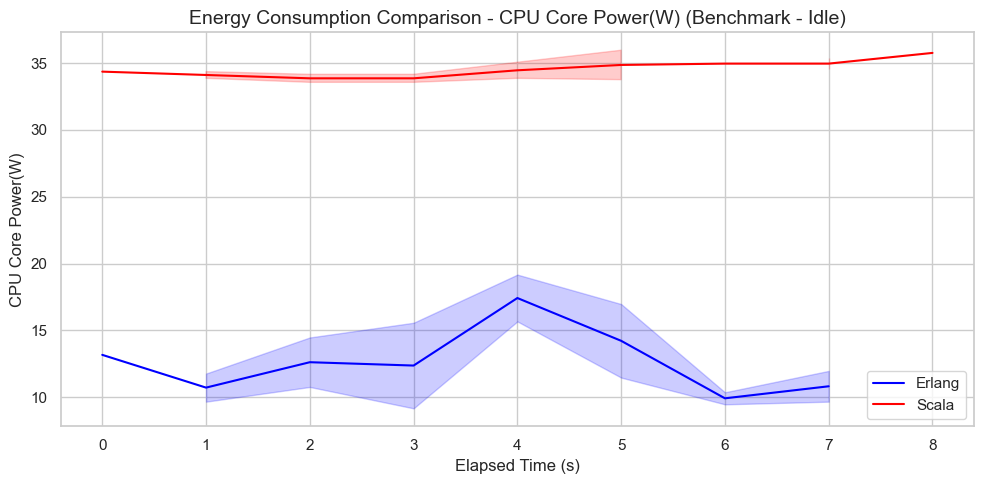

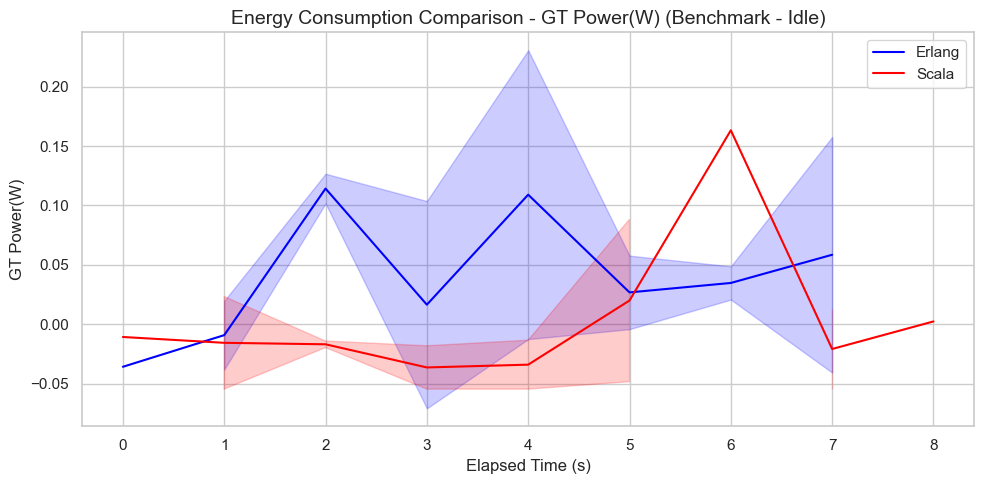

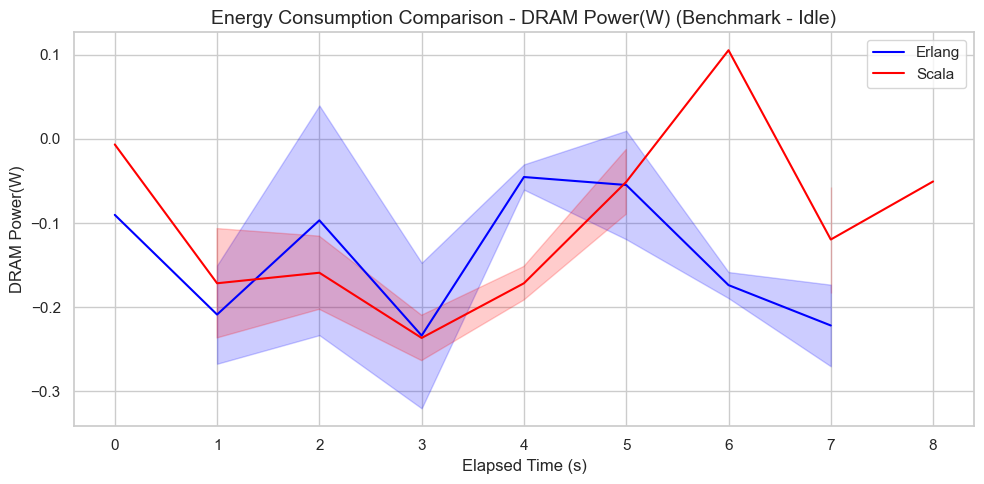

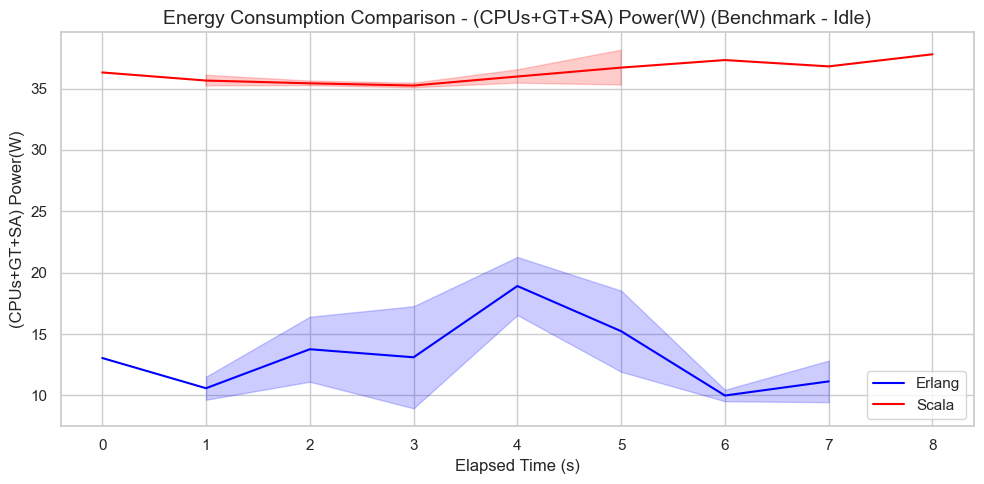

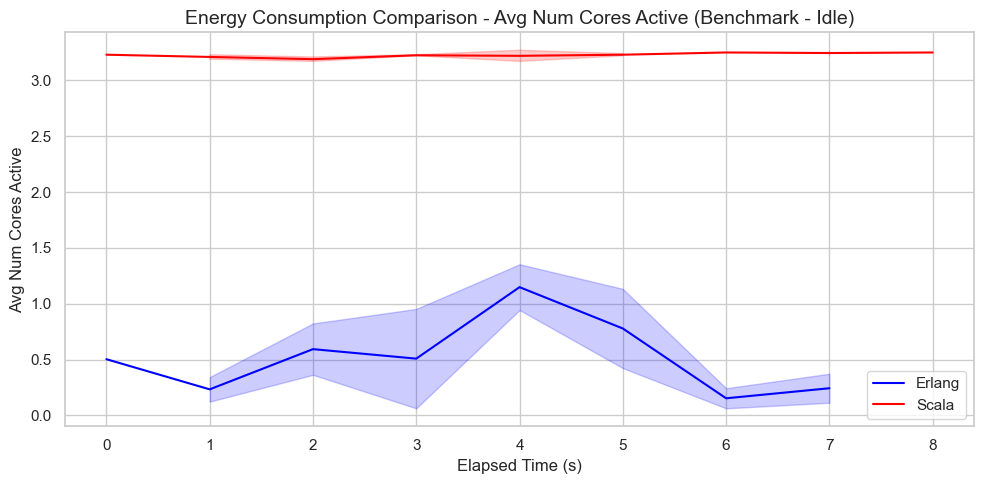

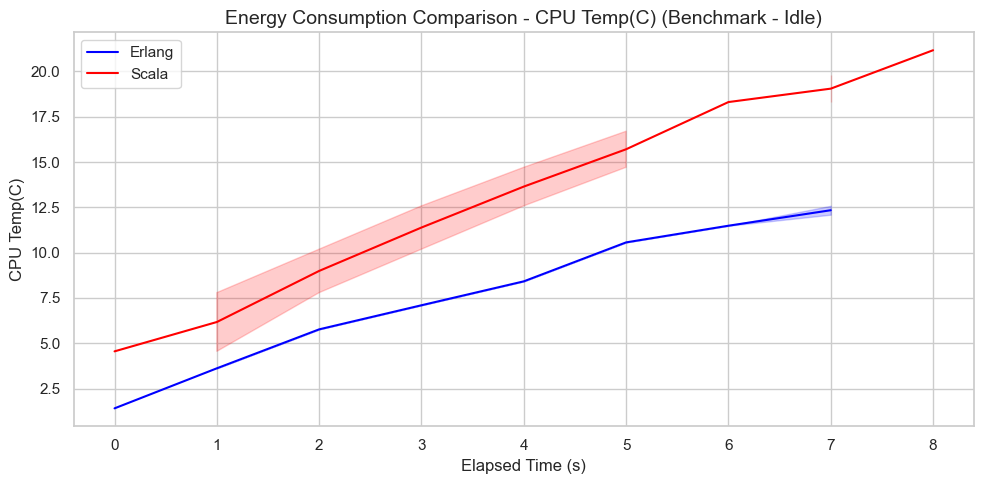

In [215]:
plot_normalized_comparison(erlang_bench_data_clean_outlier, scala_bench_data_clean_outlier, erlang_idle_data_clean_outlier,scala_idle_data_clean_outlier, "Energy Consumption Comparison")